# Mass Lumping for dual cell spaces

### by M. Wess, 2024
*This Notebook is part of the `dualcellspaces` [documentation](https://ngsolve.github.io/dcm) for the addon package implementing the Dual Cell method in [NGSolve](https://ngsolve.org).*

In [3]:
from ngsolve import *
import dualcellspaces as dcs
import matplotlib.pyplot as pl
import numpy as np

## Dual cell integration rules

Since our spaces consist of functions which are smooth (polynomials) on the single cells (instead of the whole elements) we cannot use the standard integration rules provided by `NGSolve` for computing itegrals.

The `dualcellspaces` package provides `dualcellspaces.GetIntegrationRules`, which returns rules which respect the cell structure. These are not the integration nodes used for generating the spaces!

{<ET.SEGM: 1>: <ngsolve.fem.IntegrationRule object at 0x790df8a87db0>, <ET.TRIG: 10>: <ngsolve.fem.IntegrationRule object at 0x790df8a87eb0>, <ET.TET: 20>: <ngsolve.fem.IntegrationRule object at 0x790df8a87fb0>}
ET.SEGM
 locnr = -1: (0.105662, 0, 0), weight = 0.25
 locnr = -1: (0.394338, 0, 0), weight = 0.25
 locnr = -1: (0.894338, 0, 0), weight = 0.25
 locnr = -1: (0.605662, 0, 0), weight = 0.25

ET.TRIG
 locnr = -1: (0.803561, 0.0982194, 0), weight = 0.0536948
 locnr = -1: (0.555556, 0.0778847, 0), weight = 0.0416667
 locnr = -1: (0.555556, 0.36656, 0), weight = 0.0416667
 locnr = -1: (0.418661, 0.290669, 0), weight = 0.0296385
 locnr = -1: (0.0982194, 0.803561, 0), weight = 0.0536948
 locnr = -1: (0.36656, 0.555556, 0), weight = 0.0416667
 locnr = -1: (0.0778847, 0.555556, 0), weight = 0.0416667
 locnr = -1: (0.290669, 0.418661, 0), weight = 0.0296385
 locnr = -1: (0.0982194, 0.0982194, 0), weight = 0.0536948
 locnr = -1: (0.0778847, 0.36656, 0), weight = 0.0416667
 locnr = -1: (0.3

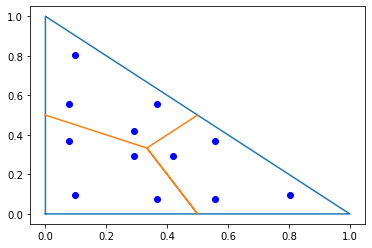

In [4]:
irs = dcs.GetIntegrationRules(2)
print(irs)

for et in irs:
  print(et)
  print(irs[et])

pl.plot([0,1,0,0],[0,0,1,0]);
pl.plot([0,1/3,0.5,1/3,0.5],[0.5,1/3,0,1/3,0.5]);

trig_points = np.array(irs[TRIG].points)
px,py = trig_points[:,0],trig_points[:,1]
pl.plot(px,py,'ob');

Using these integration rules we may compute the exact mass matrices

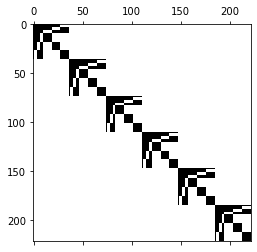

In [5]:
order = 3

irs = dcs.GetIntegrationRules(2*order+2)
mesh = Mesh(unit_square.GenerateMesh(maxh=0.5))
#fes = dcs.HCurlDualCells(mesh,order=order)
fes = dcs.H1PrimalCells(mesh,order=order)
u,v = fes.TnT()

M = BilinearForm(u*v*dx(intrules=irs)).Assemble().mat
pl.spy(M.ToDense());

## Mass lumping

We want to explot the fact that we used nodal basis functions with respect to the nodes of Gauss-Radau integration rules. Thus we need to assemble the mass matrices approximated by these integration rules.

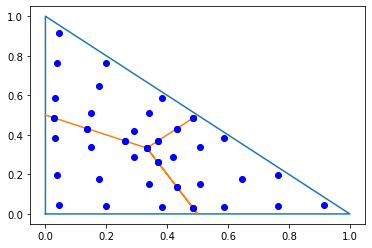

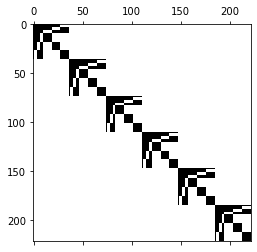

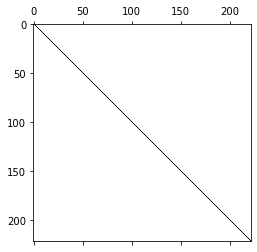

In [7]:
irs_fes = fes.GetIntegrationRules()

pl.plot([0,1,0,0],[0,0,1,0]);
pl.plot([0,1/3,0.5,1/3,0.5],[0.5,1/3,0,1/3,0.5]);

trig_points = np.array(irs_fes[TRIG].points)
px,py = trig_points[:,0],trig_points[:,1]
pl.plot(px,py,'ob');

M = BilinearForm(u*v*dx(intrules=irs_fes)).Assemble().mat
pl.figure()
pl.spy(M.ToDense());
M_diag = M.DeleteZeroElements(1e-10)
pl.figure()
pl.spy(M_diag.ToDense());

### Exercises:
* Explain why we need apply the function `DeleteZeroElements`. Use the function `BaseMatrix.nze` to check the number of non-zero elements in the assembled matrix
* Look at the sparsity pattern of the exact and lumped mass matrix for the `HCurlDualCells` and `H1DualCells` spaces.

## Application of (inverse) lumped mass matrices

Since the entries corresponding to basis functions of the dual elements are not stored together the block structure is less obvious here. Exploiting this block structure is implemented in the finite element spaces. The mass matrices may be accessed via `FESpace.Mass`:

In [ ]:
from time import time

order = 3

irs = dcs.GetIntegrationRules(2*order+2)
mesh = Mesh(unit_cube.GenerateMesh(maxh=0.3))
fes = dcs.HCurlDualCells(mesh,order=order)

print("ndof = ",fes.ndof)

irs_fes = fes.GetIntegrationRules()
u,v = fes.TnT()

with TaskManager():
  now = time()
  M_exact = BilinearForm(u*v*dx(intrules=irs)).Assemble().mat
  exacttime = time()-now

  now = time()
  M_supersparse = fes.Mass()
  stime = time()-now

  print('#### assembling ####')
  print('exact: {}s'.format(exacttime))
  print('supersparse: {}s'.format(stime))


  now = time()
  M_exact_inv = M_exact.Inverse(inverse='sparsecholesky')
  exacttime = time()-now

  now = time()
  with TaskManager():
    M_supersparse_inv = M_supersparse.Inverse()
  stime = time()-now
  print('#### factorization ####')
  print('exact: {}s'.format(exacttime))
  print('supersparse: {}s'.format(stime))

  n = 10
  tmp = M_exact.CreateVector()
  tmp.SetRandom()
  tmp2 = M_exact.CreateVector()

  now = time()
  for i in range(n):
    tmp2.data = M_exact_inv * tmp
  exacttime = time()-now

  now = time()
  for i in range(n):
    tmp2.data = M_supersparse_inv * tmp
  stime = time()-now

  print('#### application ####')
  print('exact: {}s'.format(exacttime))
  print('supersparse: {}s'.format(stime))